In [122]:
import numpy as np
import pandas as pd

from sklearn import mixture as mix

import matplotlib.pyplot as plt 
import jhtalib as jhta
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

import scipy
import statsmodels.api as sm


import bt
import ffn
import datetime 


#AlphaVantage Key insert quandl and tiingo also
key = 'AVC65FM7A32OFUBP'

from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries


ti = TechIndicators(key=key, output_format='pandas')
ts = TimeSeries(key=key, output_format='pandas', indexing_type='date')


In [123]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [124]:
data = bt.get('spy', start='1997-01-01')

In [125]:
data.head()

,spy
Date,
1997-01-02,50.166637
1997-01-03,50.886654
1997-01-06,50.441986
1997-01-07,51.056068
1997-01-08,50.611412


In [126]:
#Get data from Tiingo

from tiingo import TiingoClient

config = {}

# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True

# If you don't have your API key as an environment variable,
# pass it in via a configuration dictionary.
config['api_key'] = "539f5b3fef6e2386a8e71ad5ba2a2b4fbc55d90a"

# Initialize

client = TiingoClient(config)
# ticker_history = client.get_dataframe("GOOGL")


start_date = '1997-01-01'
df = client.get_dataframe('aapl', startDate=start_date)

In [127]:
df.head()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
date,,,,,,,,,,,,
1997-01-02,0.662338,0.670223,0.654453,0.666123,35778435,21.00,0.0,21.25,20.75,21.12,1.0,1277800
1997-01-03,0.685993,0.701763,0.662338,0.666123,29929229,21.75,0.0,22.25,21.00,21.12,1.0,1068900
1997-01-06,0.563618,0.578442,0.544063,0.555733,470708470,17.87,0.0,18.34,17.25,17.62,1.0,16811000
1997-01-07,0.551948,0.575603,0.551948,0.571503,244233044,17.50,0.0,18.25,17.50,18.12,1.0,8722600
1997-01-08,0.555733,0.579388,0.547848,0.575603,275033075,17.62,0.0,18.37,17.37,18.25,1.0,9822600


In [128]:
df.columns

Index(['adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'close',
       'divCash', 'high', 'low', 'open', 'splitFactor', 'volume'],
      dtype='object')

In [129]:
df = df[['adjClose', 'adjHigh', 'adjLow', 'adjOpen']]
df = df.rename( columns={'adjClose': 'Close','adjHigh':'High', 'adjLow': 'Low','adjOpen':'Open'})


In [130]:
df.head()

,Close,High,Low,Open
date,,,,
1997-01-02,0.662338,0.670223,0.654453,0.666123
1997-01-03,0.685993,0.701763,0.662338,0.666123
1997-01-06,0.563618,0.578442,0.544063,0.555733
1997-01-07,0.551948,0.575603,0.551948,0.571503
1997-01-08,0.555733,0.579388,0.547848,0.575603


# Define Predictor/Independent Variables
#### calculate the 10-day rolling  average, correlation, RSI, difference between Open and yesterday close,  differnce today and yesterday closes.

In [131]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])

# # df['RSI'] = pd.DataFrame(jhta.RSI(df,n=10, price='adjClose'),index=df.index)

df['RSI'] = pd.DataFrame(jhta.SAR(df, af_step=0.2, af_max=0.2),index=df.index)

df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)

df = df.dropna()
X = df.iloc[:,:9]

In [132]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'S_10', 'Corr', 'RSI', 'Open-Close',
       'Open-Open'],
      dtype='object')

In [133]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'S_10', 'Corr', 'RSI', 'Open-Close',
       'Open-Open'],
      dtype='object')

In [134]:
X = df

In [135]:
X.tail()

,Close,High,Low,Open,S_10,Corr,RSI,Open-Close,Open-Open
date,,,,,,,,,
2018-12-11,168.63,171.79,167.00,171.66,175.626,0.587219,176.323536,2.06,6.66
2018-12-12,169.10,171.92,169.02,170.40,175.112,0.825258,173.724829,1.77,-1.26
2018-12-13,170.95,172.57,169.55,170.49,174.113,0.787631,163.330000,1.39,0.09
2018-12-14,165.48,169.08,165.28,169.00,172.706,0.820926,165.178000,-1.95,-1.49
2018-12-17,163.94,168.35,162.73,165.45,171.242,0.823232,172.570000,-0.03,-3.55


#  Define Target/Dependent Variable
#### If the tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1),  else we will sell it (-1).

In [136]:
y = np.where (df['Close'].shift(-1) > df['Close'],1,-1) #mean revert vs. TF, Long vs. Short
y

array([-1,  1, -1, ..., -1, -1, -1])

# Split The Dataset
#####  We will split the dataset into a training dataset and test dataset. We will use 70% of our data to train and the rest 20% to test. To do this, we will create a split variable which will divide the data frame in a 70-30 ratio. ‘X_train’ and ‘Y_train’ are the train dataset. ‘X_test’ and ‘Y_test’ are the test dataset.

In [137]:
split = int(0.75*len(df))

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

#  Instantiate The Logistic Regression
#### We will instantiate the logistic regression in Python using ‘LogisticRegression’ function and fit the model on the training dataset using ‘fit’ function.

In [138]:
model = LogisticRegression()

model = model.fit (X_train,y_train)

# Examine The Coefficients

In [139]:
eee = (zip(X.columns, np.transpose(model.coef_)))
pd.DataFrame(list(eee))

,0,1
0,Close,[-0.35787550153879755]
1,High,[0.2200277709674234]
2,Low,[0.28226371440463455]
3,Open,[-0.06764125060820039]
4,S_10,[-0.03626539641304208]
5,Corr,[-0.07207046488855441]
6,RSI,[-0.03963239589827793]
7,Open-Close,[0.14505469098624033]
8,Open-Open,[-0.09631345694529987]


# Calculate Class Probabilities

In [140]:
probability = model.predict_proba(X_test)

print (probability)

[[0.54058902 0.45941098]
 [0.50323581 0.49676419]
 [0.48904836 0.51095164]
 ...
 [0.3702422  0.6297578 ]
 [0.43549717 0.56450283]
 [0.39958526 0.60041474]]


# Predict Class Labels

In [141]:
predicted = model.predict(X_test)

# Evaluate The Model
#### Confusion Matrix

In [142]:
print(metrics.confusion_matrix(y_test, predicted)) 

[[203 451]
 [218 506]]


In [143]:
print(metrics.classification_report(y_test, predicted)) 

             precision    recall  f1-score   support

         -1       0.48      0.31      0.38       654
          1       0.53      0.70      0.60       724

avg / total       0.51      0.51      0.50      1378



In [144]:
print(model.score(X_test,y_test))

0.5145137880986937


# Create Trading Strategy Using The Model

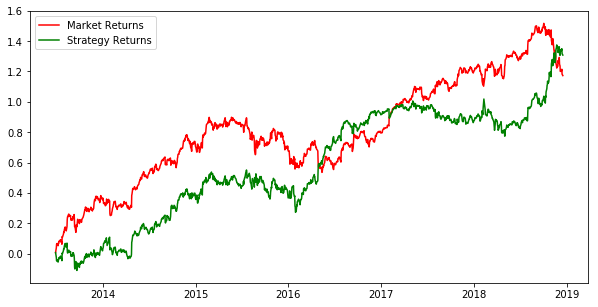

In [145]:
df['Predicted_Signal'] = model.predict(X)
df['Market_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Market_returns = np.cumsum(df[split:]['Market_returns'])

df['Startegy_returns'] = df['Market_returns']* df['Predicted_Signal'].shift(1)

Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Market_returns, color='r',label = 'Market Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()

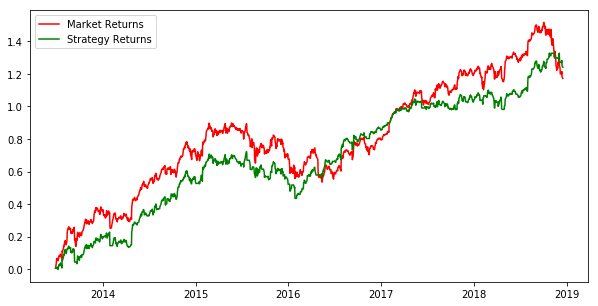

In [72]:
df['Predicted_Signal'] = model.predict(X)
df['Market_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Market_returns = np.cumsum(df[split:]['Market_returns'])

df['Startegy_returns'] = df['Market_returns']* df['Predicted_Signal'].shift(1)

Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Market_returns, color='r',label = 'Market Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()

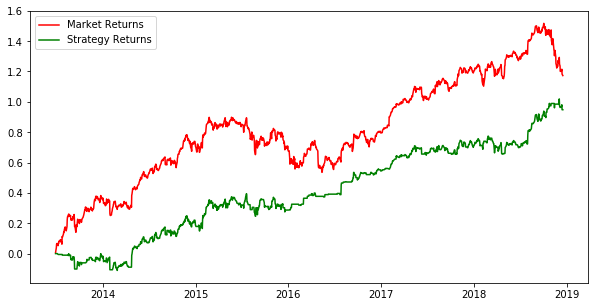

In [48]:
df['Predicted_Signal'] = model.predict(X)
df['Market_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Market_returns = np.cumsum(df[split:]['Market_returns'])

df['Startegy_returns'] = df['Market_returns']* df['Predicted_Signal'].shift(1)

Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Market_returns, color='r',label = 'Market Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()